# Character Segmentation using Character Classifier
This is experimental solution which tries to separete characters in image using pretrained character classifier.

**UNFINISHED**

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

import ipywidgets as widgets
from IPython.display import display, clear_output
from operator import itemgetter
import unidecode

sys.path.append('src')
from ocr import page, words
from ocr.normalization import word_normalization, letter_normalization
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char
from ocr.helpers import implt, resize

plt.rcParams['figure.figsize'] = (12, 9)

### Gloval Variables

In [3]:
IMG = "text1"
LANG = 'en'
CLASS = 53

## Load Image and Separate Words

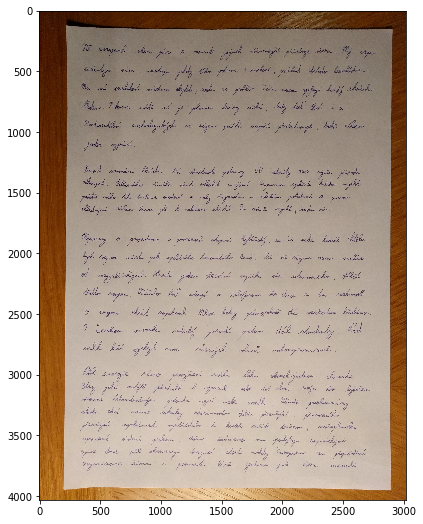

In [4]:
image = cv2.cvtColor(cv2.imread("data/pages/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

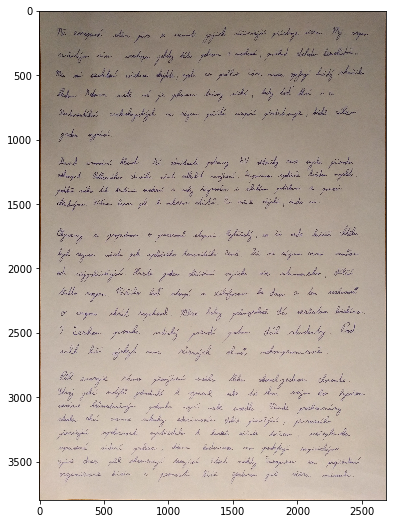

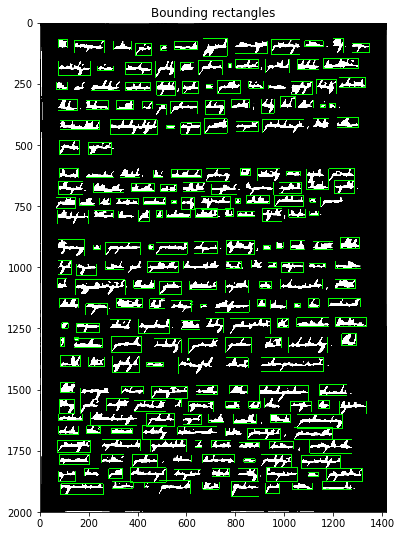

In [5]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Trained Model

In [6]:
char_classifier = Model('models/char-clas/' + LANG + '/CharClassifier', operation='y_conv')
print("Successfully loaded.")

INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier
Successfully loaded.


In [7]:
WORDS = []
with open('data/dictionaries/' + LANG + '_50k.txt') as f:
    for line in f:
        if LANG == 'en':
            WORDS += [unidecode.unidecode(line.split(" ")[0])]
        else:
            WORDS += [line.split(" ")[0]]

In [8]:
print(WORDS[:10])

['you', 'i', 'the', 'to', 'a', 'it', 'and', 'that', 'of', 'is']


## Applying Model

In [9]:
class Cycler:
    """ Cycle through boxes, separate words """
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box

        self.nextImg()
    
    def separateWord(self, img):
        """ Separating word into letters """
        implt(img, 'gray')
        self.img = img
        self.run = True
        
        self.recWordFind('', 0)
        
#         print(gaps)
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#         for gap in gaps:
#             cv2.line(img, (gap,0),(gap,60),(0,255,0),1)
        
#         implt(img)
        
    def recWordFind(self, word, x):
        if self.run:
            if x + 10 < self.img.shape[1]:
                gaps = self.findMax(x)
                for gap in gaps:
                    if gap[1][0] > 0.7 and (gap[0].islower() or x == 0):
                        self.recWordFind(word+gap[0], x+gap[1][1])
            else:
                if word.lower() in WORDS:
#                     print('RESULT:')
#                     self.run = False
                    print(word)

        
    def findMax(self, x):
        """ Find max letter from given position x """        
        offset = 6    # Test different values
        
        idx = 0
        idx += offset
        
        d = {}
        for i in range(CLASS):
            d[idx2char(i)] = [0, 0]
            
        while (x + idx <= self.img.shape[1] and idx <= 120):
            crop = self.img[:, x:x + idx]
            char, dim = letter_normalization(crop, is_thresh=True, dim=True)
            if dim[0] > 4 and dim[1] > 4:
                values = char_classifier.run([char.flatten()])
                
                sm = self.softmax(values)[0]
                l = idx2char(np.argmax(sm))
                d[l] = d[l] if d[l][0] > max(sm) else [max(sm), idx]
                
            idx += 2

        top3 = sorted(d.items(), key=itemgetter(1), reverse=True)[:5]
        #print(top3)
        #print()
        return top3
    
            
    def softmax(self, x):
        """ Compute softmax values for each sets of scores in x """
        return np.exp(x) / np.sum(np.exp(x), axis=1)
            

    def nextImg(self, btn=None):
        """ Getting next image from the array """
        clear_output()
        
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = resize(self.image[y1:y2, x1:x2], self.height, True)                      
            implt(img, t='Original')  

            self.separateWord(
                word_normalization(
                    img,
                    self.height,
                    border=False,
                    tilt=True,
                    hyst_norm=True))

            # Printing index for recovery
            print("Index: " + str(self.index))
            
            # Create button for cycling through images
            bNexi = widgets.Button(description="Next Image")
            bNexi.on_click(self.nextImg)
            display(bNexi)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

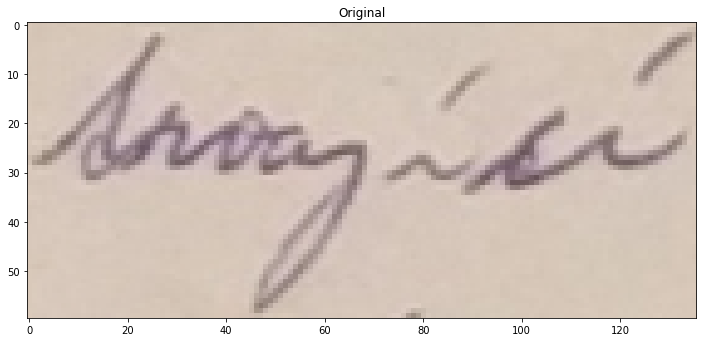

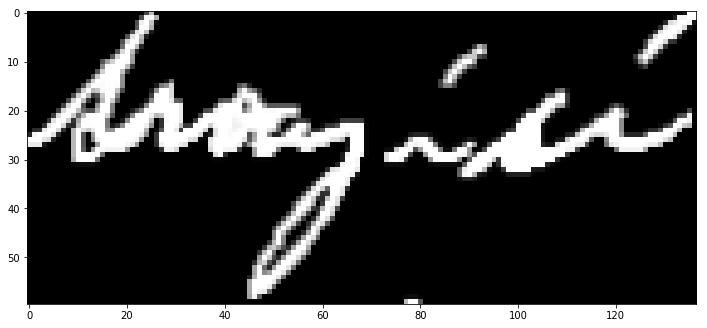

um
uni
tm
tum
tim
tani
tam
mei
mi
item
ibm
Index: 11


Button(description='Next Image', style=ButtonStyle())

In [10]:
LAST_INDEX = 10
cycler = Cycler(crop, bBoxes, LAST_INDEX)